In [1]:
import tensorflow.compat.v1 as tfv1
gpu_options = tfv1.GPUOptions(allow_growth=True)
session = tfv1.InteractiveSession(config=tfv1.ConfigProto(gpu_options=gpu_options))

import numpy as np
%matplotlib inline
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import tensorflow as tf
tf.compat.v1.set_random_seed(1234)

In [2]:
dir_img = 'M:/TRABAJO CLASE/MATERIAS/(T4) Procesamiento de Datos/Proyecto Final/Datasets/Acute Lymphoblastic Leukemia (ALL) image dataset/Segmented/datos/'
datos_split = 'M:/TRABAJO CLASE/MATERIAS/(T4) Procesamiento de Datos/Proyecto Final/Datasets/Acute Lymphoblastic Leukemia (ALL) image dataset/Segmented/split/'

# Después se utilizarán los siguientes directorios para las imagenes divididas:
train_dir = datos_split + 'train/'
test_dir  = datos_split + 'test/'
val_dir  = datos_split + 'val/'

# import splitfolders
# splitfolders.ratio(dir_img, output = datos_split,
#                   seed = 42, ratio = (0.7, 0.2, 0.1),
#                   group_prefix = None)

In [3]:
bs=20         #Setting batch size
from tensorflow.keras.preprocessing.image import ImageDataGenerator
param_data_aug = ImageDataGenerator(rescale =      1./255,           # Normalizar los datos (con valores entre 0 y 1)
                                    zoom_range =       [.99, 1.01],  # Aplicar un zoom aleatorio entre un valor minimo de 0.99 y máximo de 1.01
                                    brightness_range = [0.8, 1.2],   # Aplicar un cambio de brillo aleatorio entre los valores propuestos
                                    fill_mode =        "constant",   # (Padding) En las orillas de la imagen, rellenar con un valor constante  
                                    horizontal_flip =  True,         # Voltear la imagen horizontalmente (aleatorio)
                                    vertical_flip= True)
size = 224 # Se define un tamaño de 224 para mantener la imagen cuadrada

# OBTENER DATOS BASE SOBRE LOS QUE SE REALIZA EL AUMENTO
datos_base = param_data_aug.flow_from_directory(directory=dir_img,batch_size=3256,shuffle=False,target_size=[size, size],class_mode='categorical')

# LEER LOS DATOS BASE DEL DIRECTORIO CON EL CONJUNTO DE DATOS
base_data, base_labels = datos_base.next()

from imblearn.over_sampling import SMOTE
oversample = SMOTE(random_state = 33)

aug_data, aug_labels = oversample.fit_resample(base_data.reshape(-1, size * size * 3), base_labels)
aug_data = aug_data.reshape(-1, size, size, 3) # se aplica el -1

print("Original: ", base_data.shape, base_labels.shape)
print("Aumentados: ", aug_data.shape, aug_labels.shape)

Found 3256 images belonging to 4 classes.
Original:  (3256, 224, 224, 3) (3256, 4)
Aumentados:  (3940, 224, 224, 3) (3940, 4)


In [4]:
from sklearn.model_selection import train_test_split

train_data, test_data, train_labels, test_labels = train_test_split(aug_data,
                                                                    aug_labels,
                                                                    test_size    = 0.2,
                                                                    random_state = 33)


train_data, val_data, train_labels, val_labels = train_test_split(train_data,
                                                                  train_labels,
                                                                  test_size =    0.2,
                                                                  random_state = 33)

print("-- IMAGENES --")
print("Entrenamiento: ", train_data.shape)
print("Validacion:    ", val_data.shape)
print("Pruebas:       ", test_data.shape)

print("")

print("-- ETIQUETAS --")
print("Entrenamiento: ", train_labels.shape)
print("Validacion:    ", val_labels.shape)
print("Pruebas:       ", test_labels.shape)

-- IMAGENES --
Entrenamiento:  (2521, 224, 224, 3)
Validacion:     (631, 224, 224, 3)
Pruebas:        (788, 224, 224, 3)

-- ETIQUETAS --
Entrenamiento:  (2521, 4)
Validacion:     (631, 4)
Pruebas:        (788, 4)


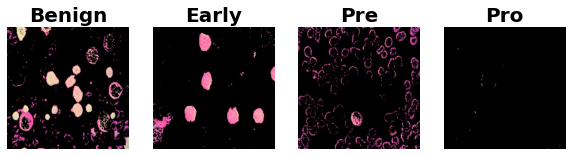

In [5]:
# Visualización de imágenes originales

from matplotlib.image import imread
import matplotlib.pyplot as plt

benign = dir_img + '/Benign/WBC-Benign-002.jpg'
benign_im = imread(benign)
early = dir_img + '/Early/WBC-Malignant-Early-001.jpg'
early_im = imread(early)
pre = dir_img + '/Pre/WBC-Malignant-Pre-001.jpg'
pre_im = imread(pre)
pro = dir_img + '/Pro/WBC-Malignant-Pro-011.jpg'
pro_im = imread(pro)

Imagenes = [benign_im, early_im, pre_im, pro_im]
Etiquetas_imagenes = ['Benign', 'Early', 'Pre', 'Pro']

for i in range(4):
    plt.figure(1, figsize = (10, 10))
    plt.subplot(1, 4, i + 1)
    plt.title(Etiquetas_imagenes[i], fontweight = 'bold', fontsize = 20)
    plt.imshow(Imagenes[i], cmap = 'gray', vmin = 0, vmax = 255)
    plt.axis('off')

plt.show()

In [6]:
# Modelo para imagenes originales
model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(64,(3,3),activation = "relu" , input_shape = (224,224,3)) ,
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(128,(3,3),activation = "relu") ,  
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(256,(3,3),activation = "relu") ,  
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(512,(3,3),activation = "relu"),  
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Flatten(), 
    tf.keras.layers.Dense(550,activation="relu"),      #Adding the Hidden layer
    tf.keras.layers.Dropout(0.1,seed = 1234),
    tf.keras.layers.Dense(400,activation ="relu"),
    tf.keras.layers.Dropout(0.3,seed = 1234),
    tf.keras.layers.Dense(300,activation="relu"),
    tf.keras.layers.Dropout(0.4,seed = 1234),
    tf.keras.layers.Dense(200,activation ="relu"),
    tf.keras.layers.Dropout(0.2,seed = 1234),
    tf.keras.layers.Dense(4,activation = "softmax")   #Adding the Output Layer
])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 222, 222, 64)      1792      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 111, 111, 64)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 109, 109, 128)     73856     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 54, 54, 128)       0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 52, 52, 256)       295168    
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 26, 26, 256)       0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 24, 24, 512)       1

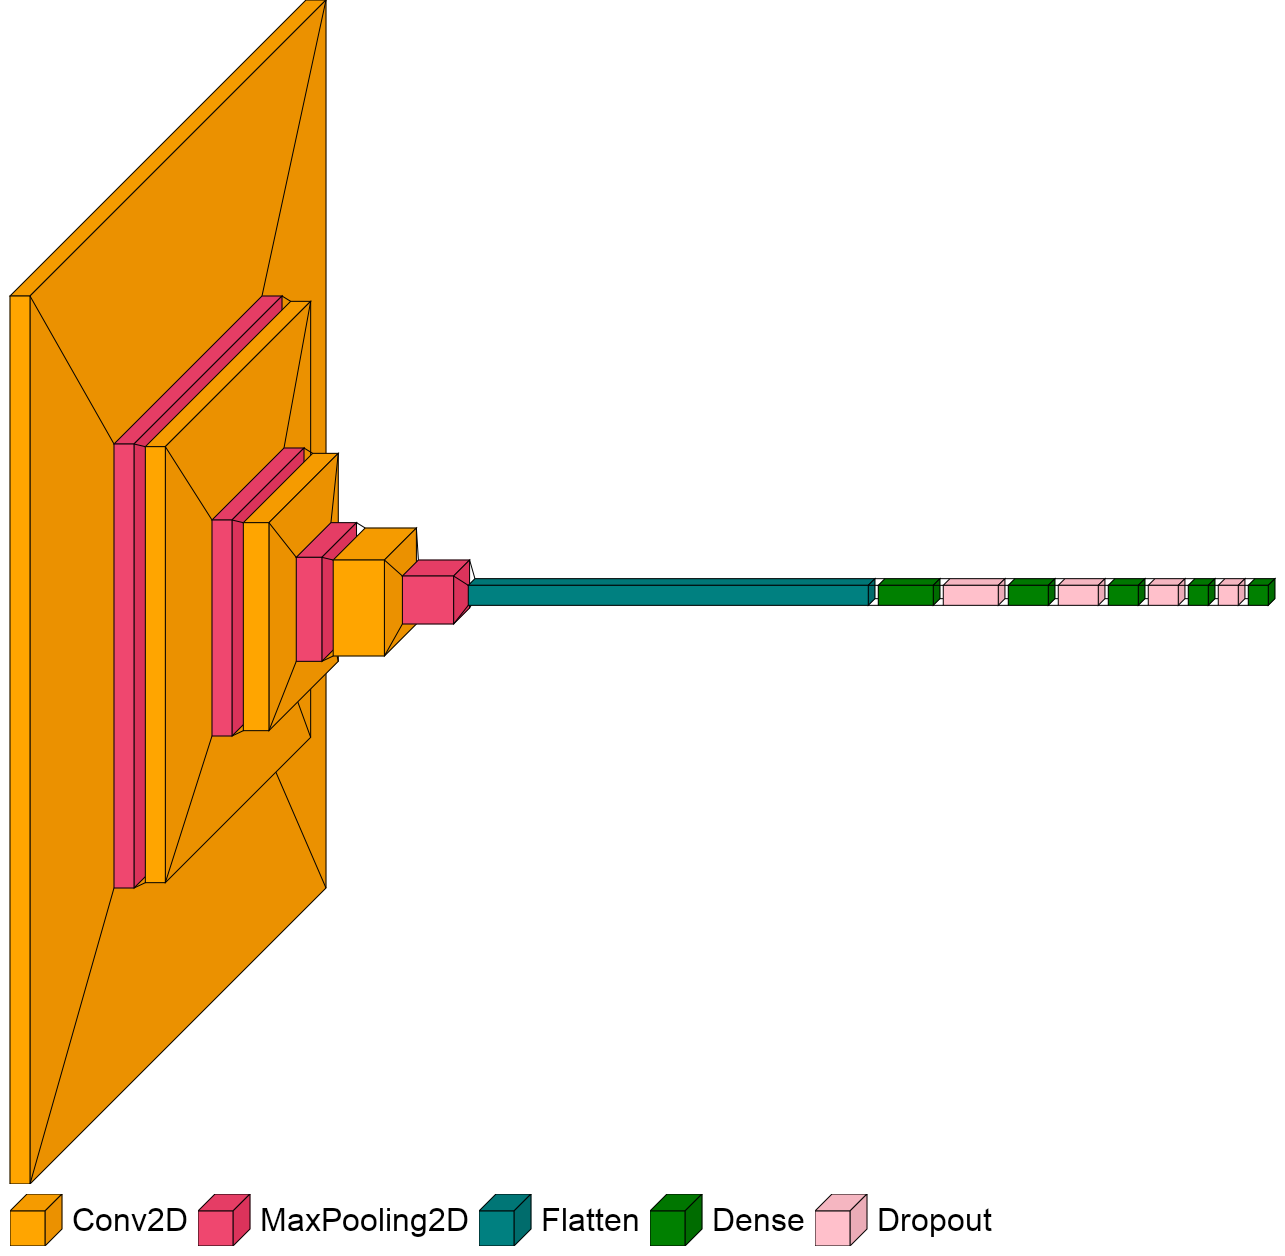

In [7]:
# Visualizar el modelo con "Visual Keras"
import visualkeras
from PIL import ImageFont
from collections import defaultdict
from keras.layers import (Dense, Dropout, Conv2D, Flatten, AveragePooling2D, BatchNormalization,
                          Activation, MaxPooling2D, ZeroPadding2D)
                          
color_map = defaultdict(dict)
color_map[Conv2D]['fill'] = 'orange'
color_map[Dropout]['fill'] = 'pink'
color_map[Dense]['fill'] = 'green'
color_map[Flatten]['fill'] = 'teal'

# visualkeras.layered_view(model, to_file = 'M:/TRABAJO CLASE/MATERIAS/(T4) Procesamiento de Datos/Proyecto Final/Datasets/Acute Lymphoblastic Leukemia (ALL) image dataset/Original/modelo.png').show()
font = ImageFont.truetype('M:/TRABAJO CLASE/MATERIAS/(T4) Procesamiento de Datos/Proyecto Final/arial/arial.ttf', 32)
visualkeras.layered_view(model, legend = True, font = font, color_map = color_map)

In [8]:
from tensorflow.keras.optimizers import RMSprop,SGD,Adam

metricas = [tf.keras.metrics.CategoricalAccuracy(name = 'categorical_accuracy'),
            tf.keras.metrics.Precision(name = 'precision'),
            tf.keras.metrics.Recall(name = 'recall'),
            tf.keras.metrics.AUC(name = 'auc')]

adam=Adam(learning_rate=0.0001)
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics = metricas)

In [9]:
EPOCHS = 30
from keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint, Callback

reducir_ta = ReduceLROnPlateau(monitor = 'val_loss', factor = 0.1, patience = 5, verbose = 1,
                               min_lr = 1e-5, mode = 'min')
parar_modelo = EarlyStopping(monitor = 'val_loss', patience = 7, verbose = 1, min_delta = 1e-5,
                             mode='min')
callbacks_lista = [parar_modelo, reducir_ta]

In [10]:
history = model.fit(train_data, train_labels, validation_data=(val_data, val_labels), callbacks=callbacks_lista, epochs=EPOCHS)

Epoch 1/30
79/79 [==============================] - 20s 156ms/step - loss: 0.9472 - categorical_accuracy: 0.5867 - precision: 0.7465 - recall: 0.3784 - auc: 0.8402 - val_loss: 0.6086 - val_categorical_accuracy: 0.7480 - val_precision: 0.8665 - val_recall: 0.5864 - val_auc: 0.9386
Epoch 2/30
79/79 [==============================] - 9s 109ms/step - loss: 0.6336 - categorical_accuracy: 0.7120 - precision: 0.7869 - recall: 0.6152 - auc: 0.9280 - val_loss: 0.5270 - val_categorical_accuracy: 0.7845 - val_precision: 0.8486 - val_recall: 0.7195 - val_auc: 0.9543
Epoch 3/30
79/79 [==============================] - 8s 106ms/step - loss: 0.5228 - categorical_accuracy: 0.7874 - precision: 0.8261 - recall: 0.7370 - auc: 0.9527 - val_loss: 0.6880 - val_categorical_accuracy: 0.7179 - val_precision: 0.7812 - val_recall: 0.6450 - val_auc: 0.9173
Epoch 4/30
79/79 [==============================] - 8s 106ms/step - loss: 0.4579 - categorical_accuracy: 0.8219 - precision: 0.8582 - recall: 0.7802 - auc: 0.9

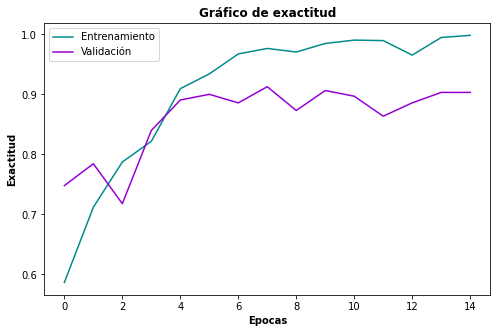

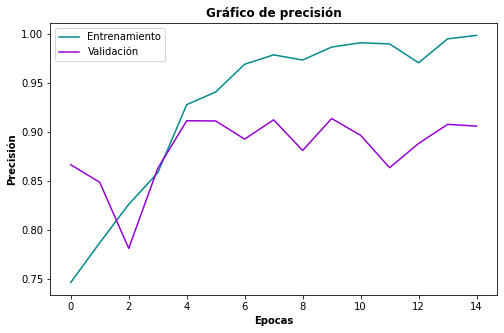

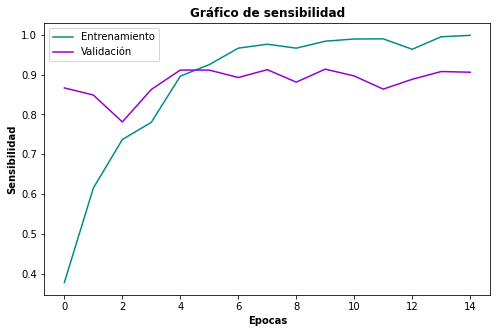

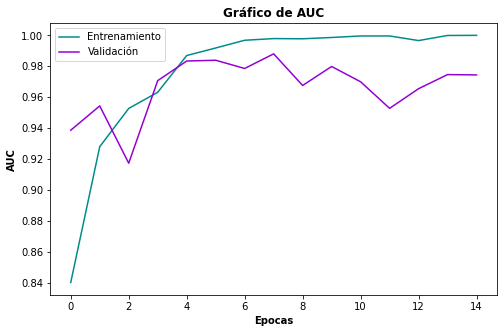

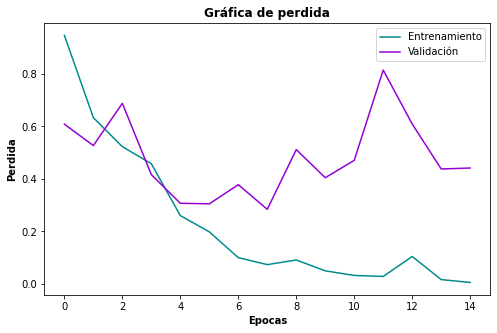

In [11]:
Epocas = range(len(history.history['categorical_accuracy']))

# Gráfico de accuracy
plt.figure(figsize = (8, 5))
plt.plot(Epocas, history.history['categorical_accuracy'], color = 'darkcyan')
plt.plot(Epocas, history.history['val_categorical_accuracy'], color = 'darkviolet')
plt.xlabel('Epocas', fontweight = 'bold')
plt.ylabel('Exactitud', fontweight = 'bold')
plt.title('Gráfico de exactitud', fontweight = 'bold')
plt.legend(['Entrenamiento', 'Validación'])
plt.show()

# Gráfico de precision
plt.figure(figsize = (8, 5))
plt.plot(Epocas, history.history['precision'], color = 'darkcyan')
plt.plot(Epocas, history.history['val_precision'], color = 'darkviolet')
plt.xlabel('Epocas', fontweight = 'bold')
plt.ylabel('Precisión', fontweight = 'bold')
plt.title('Gráfico de precisión', fontweight = 'bold')
plt.legend(['Entrenamiento', 'Validación'])
plt.show()

# Gráfico de recall
plt.figure(figsize = (8, 5))
plt.plot(Epocas, history.history['recall'], color = 'darkcyan')
plt.plot(Epocas, history.history['val_precision'], color = 'darkviolet')
plt.xlabel('Epocas', fontweight = 'bold')
plt.ylabel('Sensibilidad', fontweight = 'bold')
plt.title('Gráfico de sensibilidad', fontweight = 'bold')
plt.legend(['Entrenamiento', 'Validación'])
plt.show()

# Gráfico de auc
plt.figure(figsize = (8, 5))
plt.plot(Epocas, history.history['auc'], color = 'darkcyan')
plt.plot(Epocas, history.history['val_auc'], color = 'darkviolet')
plt.xlabel('Epocas', fontweight = 'bold')
plt.ylabel('AUC', fontweight = 'bold')
plt.title('Gráfico de AUC', fontweight = 'bold')
plt.legend(['Entrenamiento', 'Validación'])
plt.show()

# Gráfica de loss
plt.figure(figsize = (8, 5))
plt.plot(Epocas, history.history['loss'], color = 'darkcyan')
plt.plot(Epocas, history.history['val_loss'], color = 'darkviolet')
plt.xlabel('Epocas', fontweight = 'bold')
plt.ylabel('Perdida', fontweight = 'bold')
plt.title('Gráfica de perdida', fontweight = 'bold')
plt.legend(['Entrenamiento', 'Validación'])
plt.show()

In [12]:
# Evaluación del modelo con datos de prueba
Evaluacion_modelo = model.evaluate(x=test_data,y=test_labels)
Evaluacion_modelo

25/25 [==============================] - 1s 51ms/step - loss: 0.3478 - categorical_accuracy: 0.9213 - precision: 0.9259 - recall: 0.9201 - auc: 0.9790


[0.3478024899959564,
 0.9213197827339172,
 0.9259259104728699,
 0.9200507402420044,
 0.9789578914642334]

In [13]:
print(f'Exactitud del conjunto de prueba: {Evaluacion_modelo[1]*100:.2f}%\n')
print(f'Presición del conjunto de prueba: {Evaluacion_modelo[2]*100:.2f}%\n')
print(f'Sensibilidad del conjunto de prueba: {Evaluacion_modelo[3]*100:.2f}%\n')
print(f'Puntaje F1 del conjunto de prueba: {2*(Evaluacion_modelo[2]*Evaluacion_modelo[3])/(Evaluacion_modelo[2]+Evaluacion_modelo[3])*100:.2f}%\n')
print(f'Área bajo la curva del conjunto de prueba: {Evaluacion_modelo[2]*100:.2f}%\n')
print(f'Perdida del conjunto de prueba: {Evaluacion_modelo[0]*100:.2f}%')

Exactitud del conjunto de prueba: 92.13%

Presición del conjunto de prueba: 92.59%

Sensibilidad del conjunto de prueba: 92.01%

Puntaje F1 del conjunto de prueba: 92.30%

Área bajo la curva del conjunto de prueba: 92.59%

Perdida del conjunto de prueba: 34.78%


In [14]:
predictions = model.predict(test_data)
predictions

array([[5.39745716e-03, 3.14803310e-02, 9.63107884e-01, 1.43030093e-05],
       [9.86827970e-01, 1.21740010e-02, 8.46631418e-04, 1.51392625e-04],
       [9.99958634e-01, 4.03749364e-05, 9.35309401e-07, 4.68564032e-08],
       ...,
       [1.47014418e-08, 3.84363990e-16, 1.12387856e-10, 1.00000000e+00],
       [9.99941707e-01, 5.17805456e-05, 5.57419980e-06, 1.02934609e-06],
       [9.28143144e-01, 4.45312448e-02, 2.05478724e-02, 6.77768141e-03]],
      dtype=float32)

In [15]:
print(test_labels)

[[0 1 0 0]
 [1 0 0 0]
 [1 0 0 0]
 ...
 [0 0 0 1]
 [1 0 0 0]
 [1 0 0 0]]


In [16]:
# Clasificación
Clasificacion = np.argmax(predictions, axis=1)

In [17]:
# Configure one hot encoded true classifications as integers
import numpy as np
rounded_test_labels=np.argmax(test_labels, axis=1)
rounded_test_labels

from sklearn.metrics import confusion_matrix
 
cm = confusion_matrix(rounded_test_labels,Clasificacion)
cm

array([[196,  10,   5,   2],
       [  7, 162,  22,   0],
       [  3,   5, 167,   0],
       [  8,   0,   0, 201]], dtype=int64)

Matriz de confusión:
[[196  10   5   2]
 [  7 162  22   0]
 [  3   5 167   0]
 [  8   0   0 201]] 



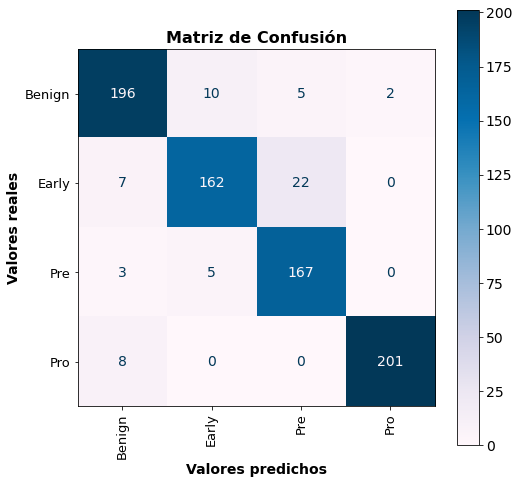



Exactitud: 92.13%

Presición: 92.13%

Sensibilidad: 92.13%

Puntaje F1: 92.13%



In [18]:
# FALTA AGREGAR AUC
# Construcción de matriz de confusión y reporte de clasificación
# https://scikit-learn.org/stable/modules/model_evaluation.html#multiclass-and-multilabel-classification
# https://scikit-learn.org/stable/modules/generated/sklearn.metrics.roc_auc_score.html

etiquetas_imagenes = ['Benign', 'Early', 'Pre','Pro']
colores = ['darkgreen', 'darkorange', 'darkred','darkblue']

from sklearn.metrics import (classification_report, confusion_matrix, accuracy_score, roc_auc_score, roc_curve, auc,
                             ConfusionMatrixDisplay, f1_score, precision_recall_curve, recall_score, precision_score)

font = {'size': 14}
plt.rc('font', **font)

# print('Índices:', train_generator.class_indices, '\n')

matriz = confusion_matrix(y_true = rounded_test_labels, y_pred = Clasificacion)

print('Matriz de confusión:')
print(matriz, '\n')

disp = ConfusionMatrixDisplay(confusion_matrix = matriz, display_labels = etiquetas_imagenes)
fig, ax = plt.subplots(figsize = (8, 8))
disp = disp.plot(xticks_rotation = 'vertical', ax = ax, cmap = 'PuBu')
plt.xticks(fontsize = 13)
plt.yticks(fontsize = 13)
plt.title('Matriz de Confusión', fontweight = 'bold', fontsize = 16)
plt.xlabel('Valores predichos', fontweight = 'bold', fontsize = 14)
plt.ylabel('Valores reales', fontweight = 'bold', fontsize = 14)
plt.show()

print('\n')
print(f"Exactitud: {accuracy_score(rounded_test_labels, Clasificacion)*100:.2f}%\n")
print(f"Presición: {precision_score(rounded_test_labels, Clasificacion, average = 'micro')*100:.2f}%\n")
print(f"Sensibilidad: {recall_score(rounded_test_labels, Clasificacion, average = 'micro')*100:.2f}%\n")
print(f"Puntaje F1: {f1_score(rounded_test_labels, Clasificacion, average = 'micro')*100:.2f}%\n")